In [23]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from sklearn.metrics import r2_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [26]:
%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
#print(tf.__version_)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0481
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0264
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0256
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0229
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0240
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_15712\280256684.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_predictions = df_predictions.resample('M').sum()
C:\Users\User\AppData\Local\Temp\ipykernel_15712\280256684.py:61: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_actual_monthly = df_cleaned[target].resample('M').sum()


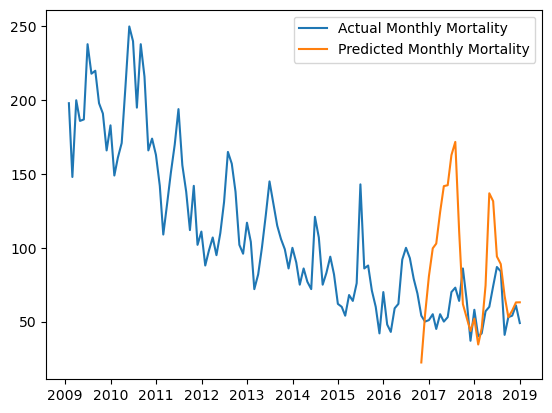

In [5]:
# Load and clean the dataset
df = pd.read_csv('GertPollCardMort.csv', sep=';', header=0, index_col=0, parse_dates=True)

# Drop rows with any NaN values
df_cleaned = df.dropna()

# Separate target variable (mortality) and use everything else as features
target = 'death_count'
features = df_cleaned.drop(columns=[target])

# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(df_cleaned[[target]])

# Step 2: Prepare the Data for LSTM
def create_sequences(data, target_data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(target_data[i + n_steps])  # Predict next day's mortality
    return np.array(X), np.array(y)

n_steps = 30  # 30 days look-back for daily data
X, y = create_sequences(scaled_features, scaled_target, n_steps)

# Reshape the data to fit LSTM input format (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 3: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(n_steps, X.shape[2])))
model.add(Dense(50, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Step 4: Train the Model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Step 5: Make Predictions for Daily Mortality
daily_predictions = model.predict(X_test)

# Inverse transform the predictions to the original mortality scale
daily_predictions_rescaled = scaler_target.inverse_transform(daily_predictions)

# Step 6: Aggregate Daily Predictions to Monthly Predictions
df_predictions = pd.DataFrame({'date': df_cleaned.index[-len(daily_predictions_rescaled):], 'predicted_mortality': daily_predictions_rescaled.flatten()})
df_predictions.set_index('date', inplace=True)

# Sum daily predictions by month
monthly_predictions = df_predictions.resample('M').sum()

# Step 7: Compare with Actual Monthly Mortality
df_actual_monthly = df_cleaned[target].resample('M').sum()

# Plot actual vs predicted monthly mortality
plt.plot(df_actual_monthly.index, df_actual_monthly.values, label='Actual Monthly Mortality')
plt.plot(monthly_predictions.index, monthly_predictions['predicted_mortality'].values, label='Predicted Monthly Mortality')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


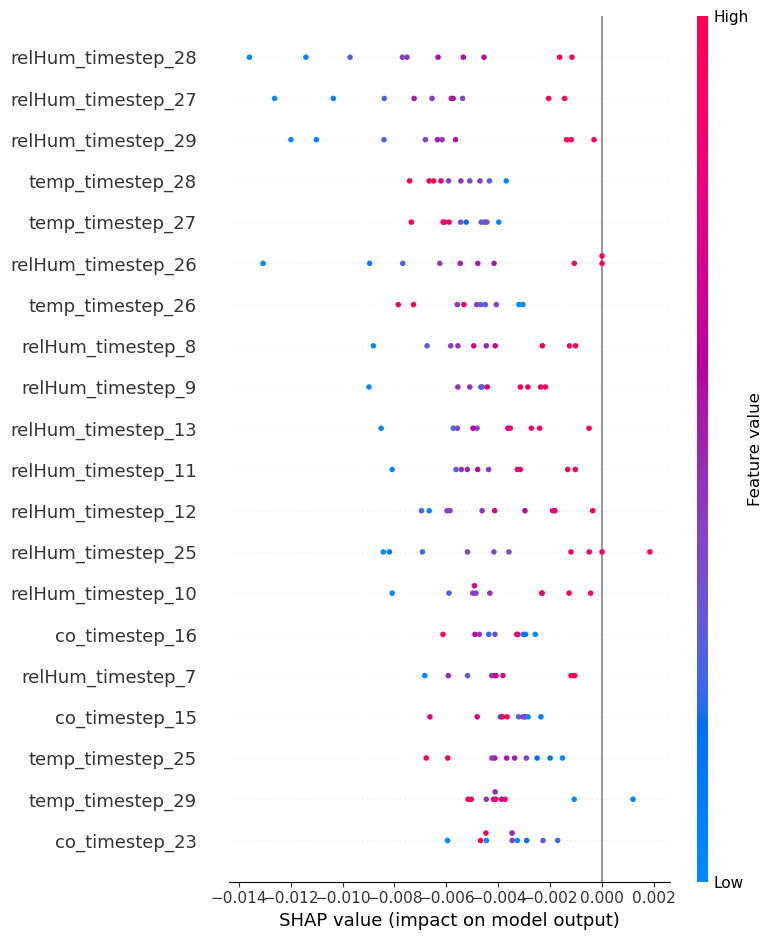

In [11]:
import shap
import numpy as np

# Sample a subset of the test set (SHAP is computationally expensive)
X_test_sample = X_test[:10]  # Use a small sample for demonstration

# Reshape the 3D data into 2D for SHAP (flatten time steps and features)
X_train_flattened = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_sample_flattened = X_test_sample.reshape((X_test_sample.shape[0], X_test_sample.shape[1] * X_test_sample.shape[2]))

# Create a SHAP KernelExplainer using the model's prediction function
explainer = shap.KernelExplainer(
    lambda x: model.predict(x.reshape((x.shape[0], n_steps, X.shape[2]))).reshape(-1),  # Ensure the output is 1D
    X_train_flattened[:10]
)

# Calculate SHAP values for the test sample
shap_values = explainer.shap_values(X_test_sample_flattened)

# Feature names (flattened time steps and features)
flattened_feature_names = [f"{feature}_timestep_{i}" for i in range(n_steps) for feature in features.columns]

# Ensure the length of feature names matches the number of features
assert len(flattened_feature_names) == X_test_sample_flattened.shape[1], "Feature names length mismatch."

# Plot summary plot of SHAP values
shap.summary_plot(shap_values, X_test_sample_flattened, feature_names=flattened_feature_names)

Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0303
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0254
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0266
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0248
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0248
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


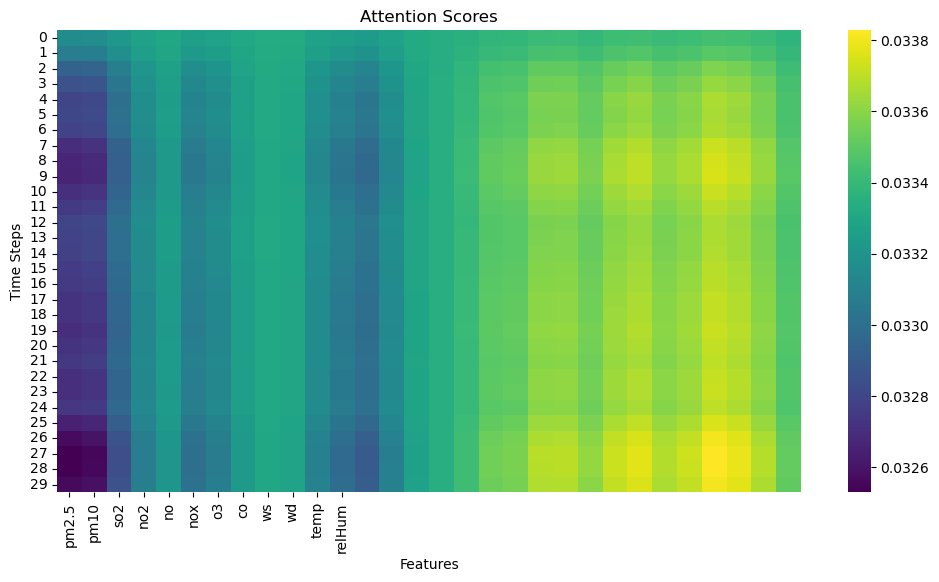

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Flatten, Dot, Softmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Define the attention mechanism
def attention_layer(inputs):
    query = Dense(1, use_bias=False)(inputs)  # Query layer
    keys = Dense(1, use_bias=False)(inputs)   # Key layer
    values = Dense(1, use_bias=False)(inputs) # Value layer

    # Compute attention scores
    scores = Dot(axes=[2, 2])([query, keys])  # Shape: (batch_size, n_steps, 1)
    scores = Softmax()(scores)  # Normalize scores
    context_vector = Dot(axes=[1, 1])([scores, values])  # Shape: (batch_size, 1, features)

    return context_vector, scores

# Define the model
def build_model(n_steps, n_features):
    inputs = Input(shape=(n_steps, n_features))
    x = LSTM(50, return_sequences=True)(inputs)
    context_vector, attention_scores = attention_layer(x)  # Apply attention mechanism and capture scores
    x = Flatten()(context_vector)
    x = Dense(50, activation='relu')(x)
    outputs = Dense(1)(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=[outputs, attention_scores])
    model.compile(optimizer='adam', loss='mse')
    return model

# Load and preprocess data
df = pd.read_csv('GertPollCardMort.csv', sep=';', header=0, index_col=0, parse_dates=True)
df_cleaned = df.dropna()
target = 'death_count'
features = df_cleaned.drop(columns=[target])

scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(df_cleaned[[target]])

def create_sequences(data, target_data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(target_data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 30
X, y = create_sequences(scaled_features, scaled_target, n_steps)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train the model
model = build_model(n_steps, X.shape[2])
history = model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Make predictions
predictions, attention_scores = model.predict(X_test)

# Rescale the predictions
daily_predictions_rescaled = scaler_target.inverse_transform(predictions)

# Extract attention scores for the first test sample (for visualization)
attention_scores_sample = attention_scores[0]

# Visualize attention scores
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape for plotting (n_steps x features)
attention_scores_sample = np.squeeze(attention_scores_sample)  # Remove unnecessary dimensions

# Plot attention scores
plt.figure(figsize=(12, 6))
sns.heatmap(attention_scores_sample, cmap='viridis', xticklabels=features.columns, yticklabels=range(n_steps))
plt.xlabel('Features')
plt.ylabel('Time Steps')
plt.title('Attention Scores')
plt.show()



casual inference

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from causalml.inference.tf import DragonNet
from causalml.metrics import regression_metrics, classification_metrics
import matplotlib.pyplot as plt
from causalml.metrics import regression_metrics

# Load and clean the dataset
dfP = pd.read_csv('GertPollCardMort.csv', sep=';', header=0, index_col=0, parse_dates=True)

# Drop rows with any NaN values
df = dfP.dropna()

# Assign treatment based on conditions
df['treatment'] = np.where((df['pm2.5'] > 40) & (df['pm10'] > 75) & (df['so2'] > 48), 'high', 
                           np.where((df['pm2.5'] > 40) & (df['pm10'] > 75), 'medium', 'low'))

# Separate target variable (mortality) and use everything else as features
y = df['death_count']
treatment = df['treatment']
X = df.drop(columns=['death_count', 'treatment'])

# Split the data into training and test sets
X_train, X_test, treatment_train, treatment_test, y_train, y_test = train_test_split(X, treatment, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the DragonNet model
dragonnet = DragonNet(hidden_layers=[64, 32])

# Fit the model on the training data
dragonnet.fit(X_train, treatment_train, y_train, epochs=5, batch_size=32)

# Predict treatment effects on the test set
treatment_effects = dragonnet.predict(X_test)

# Print the average treatment effect (ATE)
ate = treatment_effects.mean()
print(f"Average Treatment Effect (ATE): {ate}")

# Evaluate performance using metrics
metrics = regression_metrics(y_test, treatment_effects)
print(f"Regression Metrics: {metrics}")

# Plot histogram of treatment effects
plt.hist(treatment_effects, bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Treatment Effects')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df['treatment_effects'] = treatment_effects
sns.boxplot(x='treatment', y='treatment_effects', data=df)
plt.title('Treatment Effects by Treatment Group')
plt.xlabel('Treatment Group')
plt.ylabel('Treatment Effect')
plt.show()